# MC886 - Projeto 3
Aluno: Mateus Feitosa Olivi  RA: 222059

# Parte 1

<p style="text-align: justify;">
&emsp; Nesta parte do projeto vou aplicar uma técnica de computação evolucionária para resolver o problema do Pac-man. O trabalho consiste em encontrar uma solução adequada para o problema, avaliando-o segundo diversos parâmetros.
</p>

<p style="text-align: justify;">
&emsp; A primeira coisa que preciso fazer é definir um modelo para se aplicar o algoritmo evolucionario, isso é, um modelo que resolve o problema do Pac-man baseando-se em um conjunto de entradas que define um cromossomo. <br>
&emsp; No tópico a seguir vou detalhar como achei o meu modelo:
</p>

### 1. Definição do modelo
<p style="text-align: justify;">
&emsp; Antes de tudo vou importar as dependências para rodar o pacman:
</p>

In [1]:
import sys, os
os.chdir(sys.path[0]+'/search')

from pacman import runGames, loadAgent
from pacman import Directions
import pacmanAgents
from util import Queue
import textDisplay
import game
import layout
import random
import graphicsDisplay

import numpy as np 

#### 1.2 Ideia inicial: 

<p style="text-align: justify;">
&emsp; Para definir o modelo usei como inspiração inicial o GreedyAgent, esse agente está definido nos arquivos do pacman, mais precisamente no arquivo pacmanAgents.py, vamos dar uma olhada no que ele faz:
</p>

In [2]:
class GreedyAgent(game.Agent):
    def __init__(self, evalFn="scoreEvaluation"):
        self.evaluationFunction = util.lookup(evalFn, globals())
        assert self.evaluationFunction != None

    def getAction(self, state):
        # Generate candidate actions
        legal = state.getLegalPacmanActions()
        if Directions.STOP in legal: legal.remove(Directions.STOP)

        successors = [(state.generateSuccessor(0, action), action) for action in legal]
        scored = [(self.evaluationFunction(state), action) for state, action in successors]
        bestScore = max(scored)[0]
        bestActions = [pair[1] for pair in scored if pair[0] == bestScore]
        return random.choice(bestActions)

def scoreEvaluation(state):
    return state.getScore()

<p style="text-align: justify;">
&emsp; Esse código é relativamente simples, no método getAction, inicialmente o agente verifica quais ações ele pode fazer, isso é, quais direção ele pode ir, desconsiderando a possibilidade do pacman ficar parado, para isso o código usa um método já implementado, que é o getLegalPacmanActions(). Após isso, para cada possível direção, o código gera os estados sucessores possíveis, utilizando o método generateSuccessor(). Por fim esse agente verifica qual desses estados tem o melhor score, utilizando a função scoreEvaluation, e então retorna qual é a melhor ação a ser executada para se obter o maior score. <br>
&emsp; Mas note, esse agente é muito simplista, e não pode ser utilizado para se aplicar um algoritmo genético, porém posso modificar ele de tal forma a obter um agente em que poderei aplicar o algoritmo. 

#### 1.3 O meu modelo
<p style="text-align: justify;">
&emsp; No GreedyAgent, o estado é avaliado segundo o score que foi feito, porém isso não é necessariamente bom, já que as vezes o pacman deve fazer desviar de um fantasma, ou então prefirir comer uma capsula ao invés de comer uma comida, ou seja, no meu modelo a avaliação do estado não será baseado, exclusivamente, no score. <br>
&emsp; Essa avaliação pode seguir a lógica de se obter algum bônus por fazer alguma ação positiva que não é contabilizada pelo score, ou seja, o pacman pode obter um bônus por se afastar de um fantasma, por estar perto de um fantasma assustado, por se aproximar de uma capsula, por consumir uma capsula, por consumir um fantasma assustado, por se aproximar de uma comida e por consumir uma comida. <br>
&emsp; Um exemplo para essa lógica: se eu tiver um alto bônus por aproximar de uma comida e um baixo bônus por ficar longe dos fantasmas, o pacman poderá morrer tentando pegar uma comida, porém na situacão oposta, o pacman ira prefirir ficar distantes dos fantasmas do que consumir comidas. <br>
&emsp; Esses bônus poderão ser regulados com pesos que serão dados a eles, esses pesos serão os parametros do meu modelo e determinará o grau de importancia para a escolha do melhor estado seguinte do pacman.<br>
&emsp; Abaixo segue o modelo que fiz baseando-se nessa lógica:<br>

In [3]:
class SmartAgent(game.Agent):    
    def __init__(self, pesos):
        self.pesos = pesos
        
    def getAction(self, state):
        legal = state.getLegalPacmanActions()
        if Directions.STOP in legal: legal.remove(Directions.STOP)
    
        currentState = state
        
        successors = [(state.generateSuccessor(0, action), action) for action in legal]
        evalueted =  [(self.evaluation(state, currentState), action) for state, action in successors]
        bestEvaluation = max(evalueted)[0]
        bestActions = [pair[1] for pair in evalueted if pair[0] == bestEvaluation]
        
        return random.choice(bestActions)
        
    def getNeighbors(self, pos, walls, visited):
        c, l = pos
        neighbors = []
        
        for i in range(-1,2,1):
            for j in range(-1,2,1):
                if(abs(i) != abs(j) and c+i < walls.width and c+i >= 0 and l+j < walls.height and l+j >= 0):
                    if(walls[c+i][l+j] == False and visited[c+i][l+j] == 0):
                        neighbors.append((c+i,l+j))             
        return neighbors
        
    def bfsDistance(self, state, posIni, endPos = None, food = False):
        queue = Queue()
        
        walls = state.getWalls()
        if(food):
            foods = state.getFood()
            
        visited = np.zeros((walls.width,walls.height))
        visited[posIni[0]][posIni[1]] = 1
                
        queue.push((posIni, 1))
        while(not queue.isEmpty()):
            current = queue.pop()
            pos = current[0]
            stepsUntilNow = current[1]
            
            if(food == True):
                if(foods[pos[0]][pos[1]] == True):
                    return stepsUntilNow
            else:
                if(pos[0] == endPos[0] and pos[1] == endPos[1]):
                    return stepsUntilNow
    
            visited[pos[0]][pos[1]] = 1
            possibles = self.getNeighbors(pos,walls, visited)
            for possibleMove in possibles:
                queue.push((possibleMove, stepsUntilNow+1))
        return -1
    
    def ghosts(self, state):
        ghostsPos = state.getGhostPositions()
        n_ghosts = len(ghostsPos)
        
        scared_timer = []
        positionsNonScared = []
        positionsScared = []
        
        for i in range(n_ghosts):
            scared_timer.append(state.getGhostStates()[i].scaredTimer)
            
        for i in range(n_ghosts):
            if(scared_timer[i] == 0):
                positionsNonScared.append(np.ceil(ghostsPos[i]))
            else:
                positionsScared.append(np.ceil(ghostsPos[i]))
            
        return positionsScared, positionsNonScared
    
    def nearstElement(self, state, posElement, pacmanPos):
        minDist = float('inf')
        for pos in posElement:
            dist = self.bfsDistance(state, pacmanPos, pos)
            if(dist < minDist):
                minDist = dist
        return minDist
            
    def countScaredGhosts(self, state):
        total=0
        for ghost in state.getGhostStates():
            if(ghost.scaredTimer !=0):
                total+=1
        return total
    
    def evaluation(self, state, currentState):
        
        p1 = self.pesos[0]   # peso relacionado à distancia do fantasma malvado 
        p2 = self.pesos[1]   # peso relacionado à distancia do fantasma assustado mais próximo
        p3 = self.pesos[2]   # peso relacionado a comer um fantasma assustado
        p4 = self.pesos[3]   # peso relacionado à distancia da comida mais próxima
        p5 = self.pesos[4]   # peso relacionado a comer uma comida
        p6 = self.pesos[5]   # peso relacionado à distancia da capsula mais próxima
        p7 = self.pesos[6]   # peso relacionado a comer uma capsula
        
        score = state.getScore()
        scaredGhosts, badGhosts = self.ghosts(state)
        pacman = state.getPacmanPosition()
        capsules = state.getCapsules()
        
        avaliacao = score
        ################## Bad Ghost in next position  #################
        if(len(badGhosts) > 0):
            distBadGhost = self.nearstElement(state, badGhosts, pacman)
            if(distBadGhost <= p1):
                return float('-inf')
            
        ################## Nearst Scared Ghosts ####################
        if(len(scaredGhosts) > 0):
            distScaredGhosts = self.nearstElement(state, scaredGhosts, pacman)
            avaliacao += p2*(1/distScaredGhosts)
            
        ############### Eat scared ghost bonus #################
        numScaredCurrent = self.countScaredGhosts(currentState)
        numScared = self.countScaredGhosts(state)
        scaredDiff = numScaredCurrent - numScared
        if(scaredDiff > 0):
            avaliacao += p3 * scaredDiff
            
        ################ Nearst food ###################
        nearestFood = self.bfsDistance(state, pacman, food = True)
        avaliacao += p4*(1/nearestFood)
        
        ################ Eat food bonus ##################
        numfood= state.getFood()
        numFoodCurrent = currentState.getFood()
        foodDiff = numFoodCurrent.count(True) - numfood.count(True)
        avaliacao += p5*foodDiff
        
        ################# Nearst capsule ################
        if(len(capsules) > 0):
            distCapsule = self.nearstElement(state, capsules, pacman)
            avaliacao += p6*(1/distCapsule)
        
        ################# Eat capsule bonus ##############
        numcapsules = len(state.getCapsules())
        numCapsulesCurrentState = len(currentState.getCapsules())
        avaliacao += p7*(numCapsulesCurrentState - numcapsules)
        
        return avaliacao

<p style="text-align: justify;">
&emsp; Note que esse agente faz o que planejei, no método getAction, inicialmente o agente verifica quais ações ele pode fazer, isso é, quais direção ele pode ir, desconsiderando a possibilidade do pacman ficar parado, para isso o código usa um método já implementado, que é o getLegalPacmanActions(). Após isso, para cada possível direção, o código gera os estados sucessores possíveis, utilizando o método generateSuccessor(). Por fim esse agente verifica qual desses estados tem uma melhor avaliação, utilizando o método evaluation. <br>
&emsp; A avaliação de um estado é feita seguindo aquela lógica que já expliquei, abaixo definirei todos os fatores que serão usados para avaliar um estado:<br>

1) Score: A avaliação do próximo estado começa com o score desse próximo estado.<br>
2) Distancia ao fantasma mais próximo: Para a posição do pacman é calculada a distancia ao fantasma mais próximo, caso ele esteja a uma distância p1 do fantasma o score será avaliado como pior possivel e terá avaliação menos infinito. O Algoritmo genético se encarregará de descobrir qual valor de p1.<br>
3) Distância ao fantasma assustado mais próximo: Para a posição do pacman é calculada a distância ao fantasma assustado mais próximo, então eu somo a avaliação do estado com um peso p2 multiplicado pelo inverso dessa distância, ou seja, menores distâncias a esses fantasmas levarão a uma melhor avaliação, o peso p2 regulará a importância de se aproximar desses fantasmas.<br>
4) Comer fantasmas: É calculada a diferença entre o número de fantasmas assustados no próximo estado e do número de fantasmas assustados no estado atual, assim posso descobrir se foram consumidos fantamas, sabendo disso eu somo a avaliação do estado com um peso p3 multiplicado pelo número de fantasmas consumidos, esse peso p3 regulará a importância de consumir esses fantasmas .<br>
5) Distância a comida mais próxima: Para a posição do pacman é calculada a distância a comida mais próxima, então eu somo a avaliação do estado com um peso p4 multiplicado pelo inverso dessa distância, ou seja, uma menor distância à comida mais próxima levará a uma melhor avaliação, o peso p4 regulará a importância de se aproximar da comida mais próxima.<br>
6) Comer comidas: É calculada a diferença entre o número de comidas no próximo estado e do número de comidas no estado atual, assim posso descobrir se comidas foram consumidas, sabendo disso eu somo a avaliação do estado com um peso p5 multiplicado pelo número de comidas consumidas, esse peso p5 regulará a importância de consumir uma comida.<br>
7) Distância a capsula mais próxima: Para a posição do pacman é calculada a distância a capsula mais próxima, então eu somo a avaliação do estado com um peso p6 multiplicado pelo inverso dessa distância, ou seja, uma menor distância à capsula mais próxima levará a uma melhor avaliação, o peso p6 regulará a importância de se aproximar das capsulas.<br>
8) Comer capsula: É calculada a diferença entre o número de capsulas no próximo estado e do número de capsulas no estado atual, assim posso descobrir se capsulas foram consumidas, sabendo disso eu somo a avaliação do estado com um peso p7 multiplicado pelo número de capsulas consumidas, esse peso p7 regulará a importância de consumir uma capsula.
</p>

<p style="text-align: justify;">
&emsp; Note que no meu código eu usei um bfs para calcular as distancias entre os elementos do tabuleiro, assim levarei em consideração as paredes.<br>
&emsp; Os pesos p1, p2, p3, p4, p5, p6 e p7 serão descobertos aplicando um algoritmo genético, ou seja, um individuo será caracterizado por uma array na forma [p1,p2,p3,p4,p5,p6,p7]<br> 
&emsp; Agora com o agente pronto posso aplicar o algoritmo genético e achar o melhor conjunto de pesos para o executar o agente. <br>

### 2. Algoritmo genético

<p style="text-align: justify;">
&emsp;Para o algoritmo genético irei utilizar a biblioteca geneticalgs, ela pode ser obtida através do pip, porém eu baixei os seus módulos do github oficial <a href="https://github.com/bobirdmi/genetic-algorithms">link aqui</a>. <br>
&emsp;Essa biblioteca faz tudo o que preciso, porém eu tive que modificá-la para obter o valor do maior e menor fitness em cada geração (o que não era feito por padrão), também adicionei um trecho de código para imprimir quando cada geração tiver sido gerada.<br>
&emsp;Uma outra modificação que fiz foi quanto ao elitismo, em aula vimos que no elitismo em uma nova geração são gerados n-1 indivíduos novos e adicionado o indivíduo de melhor fitness da geração anterior, porém nessa biblioteca isso era diferente, nela, quando o elitismo era ativado, a nova geração tinha n indivíduos novos e também o indivíduo de melhor fitness da geração anterior, ou seja, a cada geração a população aumentava em 1 indivíduo, a modificação que fiz foi para que o elitismo ficasse igual o que foi visto em aula.<br>
&emsp;A versão com todas essas modificações da biblioteca está na pasta geneticalgsmod.
</p> 

#### 2.1 Parâmetros da biblioteca
Vou iniciar apresentando os parâmetros da biblioteca que eu vou usar:<br>
1) fitness_func (function): A funcao de fitness será usada.<br>
2) optim (str): Qual tipo de fitness será feito, isso é, se iremos maximizar a função de fitness (parâmetro 'max') ou se iremos minimiza-la (parâmetro 'min').<br>
3) selection (str): Tipo de seleção que irá ser feita, "rank", "roulette" ou "tournament".<br>
4) tournament_size (int): Define o tamanho do torneio no caso em que 'selection' == 'tournament'.<br>
5) mut_prob (float): Probabilidade de ocorrer mutação.<br>
6) mut_type (int): Nesse parâmetro se define quantos genes irão sofrer mutação.<br>
7) cross_prob (float): Probabilidade de ocorrer crossover.<br>
8) cross_type (int): Define o tipo de crossover, singlepoint (1), doublepoint (2), multipoint (> 2).<br>
9) elitism (True, False): Habilita ou desabilita o elitismo.<br>

<p style="text-align: justify;">
&emsp; Durante o treinamento das populações irei deixar explicito como aplicarei esses parametros
</p>

### 3. Treinamento
<p style="text-align: justify;">
&emsp; Agora vou fazer o treinamento incluindo os fantasmas para todos os layouts especificados, que são: smallClassic, mediumClassic e originalClassic.<br>
&emsp;Primeiro vou definir os critérios e parâmetros que serão usados para fazer a evolução:<br>

#### 3.1 Critérios para o treinamento
<p style="text-align: justify;">

1) População inicial: Para aplicar o algoritmo genético irei utilizar uma população de 70 indivíduos, como tenho 7 genes em cada cromossomo, pensei que com 70 indivíduos eu terei uma variação de 10 valores diferentes para cada gene.<br>
2) Critério de parada: Meu critério de parada será o número de gerações, no meu caso vou escolher 40 gerações.<br>
3) Técnica de seleção: Como critério de seleção irei usar seleção por ranqueamento, como o problema do pacman está relacionado a pegar todas as comidas do tabuleiro com o maior score possível e baseando na maneira na qual eu modelei o problema, não acho que utilizar o ranqueamento me levará há um maxímo local.<br>
4) Técnica de crossover: irei utilizar um crossover singlepoint.<br>
5) Técnica de mutação: irei utilizar a técnica padrão da biblioteca que eu escolhi, o método aplicado é o seguinte: se escolhe o número n de genes que será aplicado a mutação e uma probabilidade p de ocorrer a mutação. Com esses dados o algoritmo irá transformar esses n genes em cadeias de bits e cada um desses bits é percorrido, então para cada um desses bits percorrido existe a probabilidade p desse bit ser invertido.<br>
6) Método de substituição: Irei utilizar o elitismo, em uma nova geração a população terá tamanho n-1 e o melhor indíviduo da geração anterior será transferido para essa nova geração.<br>
7) Taxa de mutação: Irei definir para a mutação ocorrer em no maxímo 1 gene e com probabilidade de inversão de cada bit de 10%, conforme descrito na Técnica de mutação.<br>
8) Taxa de crossover: O singlepoint crossover irá ocorrer com probabilidade de 90%.<br>
9) Função de fitness: Dado um indivíduo (conjunto dos pesos), minha função de fitness retornará o score médio de 5 jogos feito por esse indivíduo.

&emsp; Agora vou definir algumas funções auxiliares que utilizarei no treinamento:<br>

#### 3.2 Funções auxiliares

<p style="text-align: justify;">
&emsp; Primeiro vou definir uma função que roda o pacman usando o agente SmartAgent e para os fantasmas RandomGhosts, que são os fantasmas que se movem aleatoriamente, além disso o parâmetro graphics define se usarei interface gráfico ou não:
</p>

In [4]:
def runGame(pesos, olayout, graphics = False):
    argumentos ={}
    pacman = SmartAgent(pesos)
    ghostType = loadAgent('RandomGhost', True)
    textDisplay.SLEEP_TIME = 0
    argumentos['layout'] = layout.getLayout(olayout)
    argumentos['pacman'] = pacman
    argumentos['ghosts'] = [ghostType( i+1 ) for i in range( 2 )]
    argumentos['display'] = textDisplay.NullGraphics()
    if(graphics):
        argumentos['display'] = graphicsDisplay.PacmanGraphics(1, frameTime = 0)
    argumentos['numGames'] = 1
    argumentos['record'] = False
    argumentos['catchExceptions'] = False
    argumentos['timeout'] = 1
    
    res = runGames(**argumentos)
    game = res[0] 

    return game

&emsp; Essa função é para plotar um gráfico de score pelo número de gerações.

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

def plotGraph(valores, titulo):
    x1 = list(range(len(valores)))
    plt.plot(x1, valores, 'o')
    plt.xlabel('Gerações', fontsize = 12)
    plt.ylabel('score', fontsize = 12)
    plt.title(titulo,fontsize = 12 )

&emsp; Essa função é para executar o jogo N vezes, e imprimir o score do jogo, se ganhou ou perdeu e a quantidade de movimento:

In [6]:
def runNtimes(olayout, pesos, n):
    status = ''
    for i in range(n): 
        game = runGame(pesos, olayout, graphics = False)
        if(game.state.isWin()):
            status = 'pacman venceu'
        else:
            status = 'pacman morreu'
        n = len(game.moveHistory)
        print('Score:', game.state.getScore(),'-', status, 'com', n, 'movimentos')

#### 3.3 Serialização
<p style="text-align: justify;">
&emsp; O algoritmo genético leva um bom tempo para obter o resultado, pesando nisso eu vou serializar os objetos após a finalização dos meus modelos, assim você, leitor, poderá utilizar os modelos achados e plotar novamente os gráfico para verificar sua autenticidade.<br>
&emsp; Abaixo segue as funções usadas para a serialização e desserialização:

In [7]:
import pickle

def serialize(caminho, objeto):
    outfile = open(caminho,'wb')
    pickle.dump(objeto,outfile)
    outfile.close()

def deserialize(caminho):
    infile = open(caminho,'rb')
    objeto = pickle.load(infile)
    infile.close()
    return objeto

#### 3.4 Layout SmallClassic
<p style="text-align: justify;">
&emsp; Iniciando os treinamentos, primeiro vou definir a função de fitness para esse tabuleiro, essa função retornará o score médio de 5 partidas, isso para evitar estocacidade dos fantasmas. Nessa função também vou definir 2 fantasmas com comportamento aleatório, e note que irei usar o meu agente que criei no tópico 1.3:

In [8]:
def fitfunctionSmallClassic(pesos):
    argumentos ={}
    pacman = SmartAgent(pesos)
    ghostType = loadAgent('RandomGhost', True)
    textDisplay.SLEEP_TIME = 0
    argumentos['layout'] = layout.getLayout( 'smallClassic' )
    argumentos['pacman'] = pacman
    argumentos['ghosts'] = [ghostType( i+1 ) for i in range( 2 )]
    argumentos['display'] = textDisplay.NullGraphics()
    argumentos['numGames'] = 5
    argumentos['record'] = False
    argumentos['catchExceptions'] = True
    argumentos['timeout'] = 1
    
    res = runGames(**argumentos)
    scores = [game.state.getScore() for game in res]
    avgScore = sum(scores) / float(len(scores))
     
    return avgScore

&emsp; Agora, vou utilizar os parâmetros e critérios que defini no tópico 3.1 para instanciar um modelo de algoritmo genético para pesos reais da biblioteca:

In [9]:
import geneticalgsmod as ge

modelSmallClassic = ge.RealGA(fitness_func = fitfunctionSmallClassic, 
                              optim='max',          #Irei maximizar o score
                              selection="rank",     #Para Seleção usarei o ranqueamento
                              mut_prob=0.10,        #Probabilidade de inverter bits na mut de 10%
                              mut_type=1,           #Mutacao ocorrerá em no maxima 1 gene de um cromossomo
                              cross_prob=0.9,       #Prob de ocorrer cross de 90%
                              cross_type=1,         #Cross singlepoint
                              elitism=True,         #Elitismo ativado
                              tournament_size=None)

&emsp; Vou iniciar uma população de 70 indivíduos e especificar que um indivíduo tem 7 genes no intervalo de [0,1000]:

In [10]:
population_size = 70
dimensao = 7         # numero de argumentos da funcao        
interval = (0,100)
modelSmallClassic.init_random_population(population_size, dimensao, interval) # iniciando a população

&emsp; Agora vou definir o número maxímo de gerações como 40 e aplicar o algoritmo:

In [11]:
max_generation = 40
fitness_progressSC, best_individualSC, worst_individualSC = modelSmallClassic.run(max_generation)

Geração 1 terminada
Geração 2 terminada
Geração 3 terminada
Geração 4 terminada
Geração 5 terminada
Geração 6 terminada
Geração 7 terminada
Geração 8 terminada
Geração 9 terminada
Geração 10 terminada
Geração 11 terminada
Geração 12 terminada
Geração 13 terminada
Geração 14 terminada
Geração 15 terminada
Geração 16 terminada
Geração 17 terminada
Geração 18 terminada
Geração 19 terminada
Geração 20 terminada
Geração 21 terminada
Geração 22 terminada
Geração 23 terminada
Geração 24 terminada
Geração 25 terminada
Geração 26 terminada
Geração 27 terminada
Geração 28 terminada
Geração 29 terminada
Geração 30 terminada
Geração 31 terminada
Geração 32 terminada
Geração 33 terminada
Geração 34 terminada
Geração 35 terminada
Geração 36 terminada
Geração 37 terminada
Geração 38 terminada
Geração 39 terminada
Geração 40 terminada


&emsp; Agora, como dito anteriormente, vou serializar os objetos para poder usar depois, irei colocar todas as saídas úteis em uma lista, irei serializar essa lista e salvar na pasta de nome save.

In [12]:
lista = [fitness_progressSC, best_individualSC, worst_individualSC, modelSmallClassic]
serialize(sys.path[0]+'/save/smallClassicData', lista)

&emsp; Agora vou desserializar a lista e restaurar o progresso do treinamento, a sequência dessas ações são inúteis se todas as células forem executas juntas. Porém, caso queira evitar o treinamento, podemos desserializar o objeto e recuperar o modelo.

In [13]:
lista = deserialize(sys.path[0]+'/save/smallClassicData')

&emsp; Definindo novamente as variaveis:

In [14]:
fitness_progress, best_individual, worst_individual, model = lista

&emsp; Agora vou plotar os gráficos do fitness médio, do melhor fitness e do pior fitness ao longo das gerações:

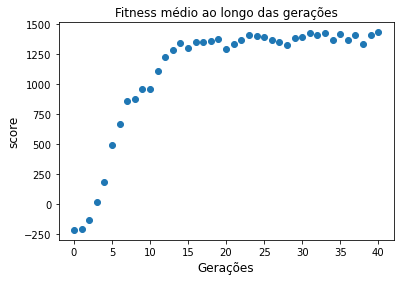

In [15]:
plotGraph(fitness_progress, 'Fitness médio ao longo das gerações')

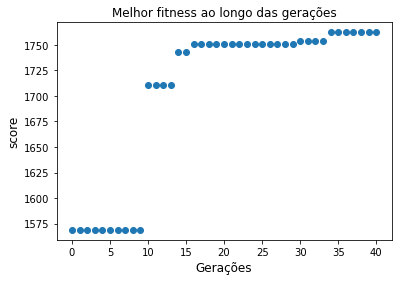

In [16]:
plotGraph(best_individual, 'Melhor fitness ao longo das gerações')

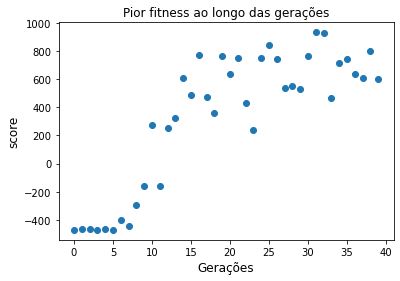

In [17]:
plotGraph(worst_individual, 'Pior fitness ao longo das gerações')

<p style="text-align: justify;">
&emsp; É possível ver que o fitness médio aumentou ao longo das gerações até se estabilizar, essa estabilização ocorreu perto da geração 20. O maior fitness ao longo das gerações subiu abruptamente na geração 10 e atingiu um valor limite na geração 15. O pior fitness ao longo das gerações também subiu, mas não tanto, além disso é possivél ver que em algumas gerações obtive que o pior fitness foi maior do que a maioria, mas se analisarmos bem é possível notar que também a partir da geração 20 os valores foram se estabilizando em um intervalo.<br>
&emsp; Agora vou pegar o melhor indivíduo e executar 10 vezes para ver o que acontece com o score:
</p>

In [18]:
melhor_individuo = model.best_solution[0]
runNtimes('smallClassic', melhor_individuo, 10)

Score: 1753.0 - pacman venceu com 289 movimentos
Score: 1742.0 - pacman venceu com 322 movimentos
Score: 1549.0 - pacman venceu com 301 movimentos
Score: 1169.0 - pacman venceu com 241 movimentos
Score: 1371.0 - pacman venceu com 235 movimentos
Score: 1727.0 - pacman venceu com 367 movimentos
Score: 1761.0 - pacman venceu com 265 movimentos
Score: 545.0 - pacman morreu com 254 movimentos
Score: 1761.0 - pacman venceu com 265 movimentos
Score: 1564.0 - pacman venceu com 256 movimentos


<p style="text-align: justify;">
&emsp; Nessa minha execução o pacman foi ótimo, obtive 90% de vitória, e um score médio de 1494, o que é muito bom para esse layout. <br>
</p>

&emsp;Vou fazer algumas execuções com a interface gráfica para dar um exemplo:

In [20]:
melhor_individuo = model.best_solution[0]
game = runGame(melhor_individuo, 'smallClassic', graphics = True)

&emsp; Como não consigo colocar a execução no notebook vou colocar um gif de uma execução:

<p style="text-align: center;">
&emsp;<img src="gifs/smallClassic.gif" width="500" align="center">
</p>

<p style="text-align: justify;">
&emsp; Nessa execução é possível perceber que os pesos estão bem regulados, o pacman foi atrás das capsulas, perseguiu os fantasmas assustados e desviou dos fantasmas não asustados, ou seja, o meu modelo e a aplicação do algoritmo genético foi um sucesso para esse layout, eu executei algumas vezes e percebi que o pacman morre apenas nos casos em que ele fica encurralado.
</p>

#### 3.5 Layout MediumlClassic
&emsp; Agora vou definir a função de fitness para o layout mediumClassic, que retornará o score da partida e irá definir 2 fantasmas com comportamento aleatório, e note que irei usar o meu agente que criei no tópico 1.3:

In [23]:
def fitfunctionMediumClassic(pesos):
    argumentos ={}
    pacman = SmartAgent(pesos)
    ghostType = loadAgent('RandomGhost', True)
    textDisplay.SLEEP_TIME = 0
    argumentos['layout'] = layout.getLayout( 'mediumClassic' )
    argumentos['pacman'] = pacman
    argumentos['ghosts'] = [ghostType( i+1 ) for i in range( 2 )]
    argumentos['display'] = textDisplay.NullGraphics()
    argumentos['numGames'] = 5
    argumentos['record'] = False
    argumentos['catchExceptions'] = True
    argumentos['timeout'] = 1
    
    res = runGames(**argumentos)
    scores = [game.state.getScore() for game in res]
    avgScore = sum(scores) / float(len(scores))
     
    return avgScore

&emsp; Agora, vou utilizar os parâmetros e critérios que defini no tópico 3.1 para instanciar um modelo de algoritmo genético para pesos reais da biblioteca:

In [24]:
import geneticalgsmod as ge

modelMediumClassic = ge.RealGA(fitness_func = fitfunctionMediumClassic, 
                              optim='max',          #Irei maximizar o score
                              selection="rank",     #Para Seleção usarei o ranqueamento
                              mut_prob=0.10,        #Probabilidade de inverter bits na mut de 10%
                              mut_type=1,           #Mutacao ocorrerá em no maxima 1 gene de um cromossomo
                              cross_prob=0.9,       #Prob de ocorrer cross de 90%
                              cross_type=1,         #Cross singlepoint
                              elitism=True,         #Elitismo ativado
                              tournament_size=None)

&emsp; Vou iniciar uma população de 70 indivíduos e especificar que um indivíduo tem 7 genes no intervalo de [0,100]:

In [25]:
population_size = 70
dimensao = 7         # numero de argumentos da funcao        
interval = (0,100)
modelMediumClassic.init_random_population(population_size, dimensao, interval) # iniciando a população

&emsp; Agora vou definir o número maxímo de gerações como 40 e aplicar o algoritmo:

In [ ]:
max_generation = 40
fitness_progressMC, best_individualMC, worst_individualMC = modelMediumClassic.run(max_generation)

Geração 1 terminada
Geração 2 terminada


&emsp; Agora, como dito anteriormente, vou serializar os objetos para poder usar depois, irei colocar todas as saídas úteis em uma lista, irei serializar essa lista e salvar na pasta de nome save.

In [9]:
lista = [fitness_progressMC, best_individualMC, worst_individualMC, modelMediumClassic]
serialize(sys.path[0]+'/save/mediumClassicData', lista)

&emsp; Agora vou desserializar a lista e restaurar o progresso do treinamento:

In [10]:
lista = deserialize(sys.path[0]+'/save/mediumClassicData')

&emsp; Definindo novamente as variaveis:

In [11]:
fitness_progress, best_individual, worst_individual, model = lista

&emsp; Agora vou plotar os gráficos do fitness médio, do melhor fitness e do pior fitness ao longo das gerações:

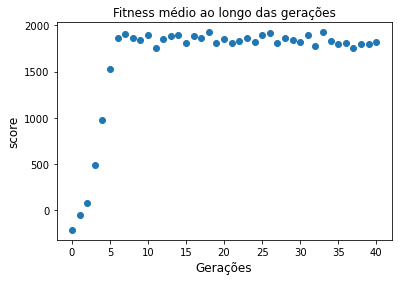

In [12]:
plotGraph(fitness_progress, 'Fitness médio ao longo das gerações')

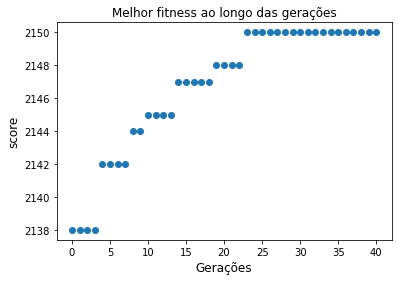

In [13]:
plotGraph(best_individual, 'Melhor fitness ao longo das gerações')

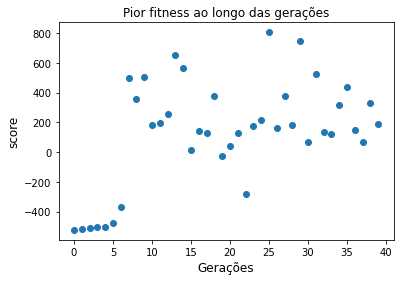

In [14]:
plotGraph(worst_individual, 'Pior fitness ao longo das gerações')

<p style="text-align: justify;">
&emsp; É possível ver que o fitness médio aumentou ao longo das gerações até se estabilizar, essa estabilização ocorreu perto da geração 5. O maior fitness ao longo das gerações foi subinda progressivamente, mas note que o score já começou alto . O pior fitness ao longo das gerações também subiu, os pontos ficaram baguncados depois da geração 10,mas pode-se notar que eles se concentraram em um intervalo.<br>
&emsp; Agora vou pegar o melhor indivíduo e executar 10 vezes para ver o que acontece com o score:
</p>

In [15]:
melhor_individuo = model.best_solution[0]
runNtimes('mediumClassic', melhor_individuo, 10)

Score: 1722.0 - pacman venceu com 442 movimentos
Score: 1530.0 - pacman venceu com 418 movimentos
Score: 1930.0 - pacman venceu com 418 movimentos
Score: 1727.0 - pacman venceu com 427 movimentos
Score: 2136.0 - pacman venceu com 400 movimentos
Score: 2128.0 - pacman venceu com 424 movimentos
Score: 686.0 - pacman morreu com 251 movimentos
Score: 1922.0 - pacman venceu com 442 movimentos
Score: 2122.0 - pacman venceu com 442 movimentos
Score: 1737.0 - pacman venceu com 397 movimentos


<p style="text-align: justify;">
&emsp; Nessa minha execução o pacman foi ótimo, obtive 90% de vitória, e um score médio de 1764, o que é muito bom para esse layout. <br>
</p>

&emsp;Vou fazer algumas execuções com a interface gráfica para dar um exemplo:

In [17]:
melhor_individuo = model.best_solution[0]
game = runGame(melhor_individuo, 'mediumClassic', graphics = True)

&emsp; Como não consigo colocar a execução no notebook vou colocar um gif de uma execução:

<p style="text-align: center;">
&emsp;<img src="gifs/mediumClassic.gif" width="500" align="center">
</p>

<p style="text-align: justify;">
&emsp; Assim como na execução para o outro layout, é possível perceber que os pesos estão bem regulados, o pacman foi atrás das capsulas, perseguiu os fantasmas assustados e desviou dos fantasmas não asustados, ou seja, o meu modelo e a aplicação do algoritmo genético foi um sucesso para esse layout. <br>
&emsp; Da mesma forma que fiz para o layout anterior, eu executei algumas vezes e percebi que o pacman morre apenas nos casos em que ele fica encurralado. Ele não se suicida para tentar comer algum elemento do mapa.<br>
</p>